In [1]:
#
#    Normal Mode Analysis (NMA):
#
#    In this notebook, we will study 
#    structural dynamics of elastic network models (ENMs) of real proteins!
#
#    This notebook is handed out Th. 5/25/17 and is due Tu. 6/13/17
# 
#    Please work through the notebook cell-by-cell with particular attention to "ANSWER"

In [2]:
#
#    Some Background:
#
#    In the NMA of an elastic network model (ENM), the underlying potential energy is based on a drastically
#    simplified force field, in which two interacting CA atoms i and j are coupled by 
#    the harmonic potential energy:
#    V(d_ij) = gamma / 2 * (d_ij - d_ij0)^2, where
#    d_ij  is the instantaneous distance between CA atoms i and j
#    d_ij0 is the equilibrium   distance between CA atoms i and j, taken, e.g. from a PDB crystal structure
#    gamma is a uniform force constant
#
#    Two CA atoms interact, if d_ij0 <= d_cutoff, a distance cutoff parameter, 
#    so that the total ENM potential energy  reads:
#
#    V = \sum_{d_{ij0}<=d_cutoff} V(d_ij)
#
#    Since these potential terms are all harmonic, we can
#    compute the Hessian of this ENM potential analytically (see below).
#
#    Optimal parameter values for gamma and d_cutoff can be determined 
#    via comparison between computed and experimental B-factors provided in a given PDB structure.
#    (In solid state physics, these B-factors, also known as Debye–Waller or temperature factors, are measures
#    of the structural flexibility (thus dynamics) of individual atoms.)
#    For given values of gamma and d_cutoff, one can compute B_enm, the B-factors determined from an ENM.
#    The values of gamma and d_cutoff, which result in B_enm values that best match the experimental B_exp values,
#    are defined to be optimal.
#    In this tutorial, we will first optimize for d_cutoff with fixed gamma by maximizing the Pearson correlation
#    between B_enm and B_exp (this turns out to be independent of gamma). Then, with optimal d_cutoff, we will 
#    optimize for gamma with the requirement that sum(B_enm) == sum(B_exp).
#

In [3]:
#    1)
#    As a first exercise, open the elastic network model (or "ANM") server at
#    http://anm.csb.pitt.edu
#    "Enter the PDB id of your protein", e.g. 4AKE, or a PDB ID of any other protein deposited at
#    http://www.rcsb.org
#    You will be able to visualize individual ENM eigen modes by selecting different values for "Modes".

In [4]:
#    1a) What kind of dynamics do you observe? (short sentence, no essays, please :-) )
#        ANSWER: We can see different vibrations.
#
#    1b) Given that you see the results of an ENM (a "network of Hookean springs" model of a protein structure),
#        can you find an explanation for why in the first eigen mode, some regions are more flexible than others?
#        ANSWER: The regions on the edge of the molecule are interact less with the other atoms and can thereby 
#        move more freely. The atoms in the center are sens forces in two oposite directions. Therefore, they are
#        not as flexible.

In [5]:
#
#    In a complete analysis of an ENM, one has to consider all eigen modes at once.
#    In the above server, this can be done by setting "Modes" to "all". 
#    However, this animation is not correct because:
#    - Only the first 20 eigen modes are shown
#    - All eigen modes are shown with constant phase difference (i.e. in synchrony).
#      Strictly speaking, this is wrong because even if the animation starts
#      at the equilibrium structure (zero elongation, zero phase difference), the eigen modes will quickly
#      get out of phase (the dynamics should get all "wobbly"). This is because
#      not all eigen modes have the same frequency (due to different eigenvalues).

In [6]:
#    2)
#    Let's produce a physically correct animation of these ENM eigen modes!
#    (first for the "A" chain of 4AKE)
#    Please execute the next cell, and then see you in the cell after

In [1]:
#
# Copyright 2012-2013, Sebastian Stolzenberg
# Department of Physiology & Biophysics at Weill Cornell Medical College, New York, NY
# Department of Physics, Cornell University, Ithaca, NY
#
# For Thesis Research in the Harel Weinstein Lab
#
# For Comments/Questions: ss629@cornell.edu
#
####################
# The code below is based on:
####################
#
# enm.py - C-alpha based elastic network model (ENM)
#
# (c) 2008 Willy Wriggers, Weill Cornell Medical College
#
# usage: ./enm.py input.pdb cutoff startmode endmode target-rms-modes target-rms-arrows
#
#     cutoff = distance cutoff for ENM, for Calphas typically 10-15A.
#     startmode = mode number (integer) of first output mode (typically 7).
#     endmode = mode number (integer) of last desired output mode.
#     target-rms-modes = desired amplitude (rmsd from input.pdb) for the output pdb files.
#     target-rms-arrows = desired amplitude (rmsd from input.pdb) for the VMD tcl arrows.
#
#     the program creates 4 files for each mode:
#     .pdb structures (deformed) and .tcl arrows for positive and negative directions (sign ambiguity).
#     both .pdb and .tcl files have eigenvalue information in the header.
#     .tcl files sourcable from VMD command console (with use of "draw delete all", "draw color red", etc)
#
#     future plan: add interpolation to extend sparsely (C-alpha) sampled deformations
#     to full atomic structure. This will take only 1-2 days extra time.

import numpy as np
from pdb_read_write_calphas import *

import matplotlib.pyplot as plt # module for plotting "a la" matlab
# this command conveniently allows you to show figures inline (i.e. within the notebook)
%matplotlib inline

PI                      = 3.14159265
R                       = 0.00198720649981139 # in kcal/mol/K 
TEMP                    = 310                 # in K

def compute_ENM(inpdb, bond_cutoff, gamma, indir = "input", verbose = True):
    ''' 
    Compute the ENM Hessian of the CA atom positions of a given pdb structure.

    Input Parameters:
    inpdb       : string,      input pdb file stem
    bond_cutoff : float,       generate an ENM movie with ENM modes startmode to endmode
    gamma       : float,       ENM movie length in units of periods of the startmode (i.e. the most dominant mode) 
    indir       : string,      (optional), input directory name
    verbose     : boolean,     (optional), print out detailed log info?
    
    Output:
    ca_list     : list,        CA atom indices
    eval        : numpy array, eigen values
    evec_trans  : numpy array, eigen vector
    '''
    # read pdb file
    atom_list  = read_pdb("input/%s.pdb" % inpdb)

    # select C-alphas
    ca_indices = carbon_alphas(atom_list)
    ca_list = []
    for i in ca_indices:
        ca_list.append(atom_list[i])
    len_ca = len(ca_list)
    if verbose:
        print("%i carbon alpha atoms extracted" % len_ca) 

    # compute (full) squared distance matrix between pairs of CA atoms
    sqrdist_matrix = np.empty((len_ca, len_ca), float)
    for i in range(len_ca):
        for j in range (i+1, len_ca):
            currsqrdist = (ca_list[i].x - ca_list[j].x) * (ca_list[i].x - ca_list[j].x) + \
                          (ca_list[i].y - ca_list[j].y) * (ca_list[i].y - ca_list[j].y) + \
                          (ca_list[i].z - ca_list[j].z) * (ca_list[i].z - ca_list[j].z)
            sqrdist_matrix[i][j] = currsqrdist
            sqrdist_matrix[j][i] = currsqrdist
    for i in range(len_ca):
        sqrdist_matrix[i][i] = 0.0

    # compute (full) connectivity matrix, one connection per pair of CA atoms
    sqrcutoff = bond_cutoff * bond_cutoff
    conn_matrix = np.empty((len_ca, len_ca), int)
    for i in range(len_ca):
        for j in range(i+1):
            conn_matrix[i][j] = 0
        for j in range(i+1,len_ca):
            if (sqrdist_matrix[i][j] <= sqrcutoff):
                conn_matrix[i][j] = 1
            else:
                conn_matrix[i][j] = 0

    # compute (full) Hessian matrix, see nma_notes_wriggers_02.pdf
    hess_matrix = np.zeros((3*len_ca, 3*len_ca), float)
    # off-diagonal
    for i in range(len_ca):
        for j in range (len_ca):
            r = [ca_list[i].x - ca_list[j].x, ca_list[i].y - ca_list[j].y, ca_list[i].z - ca_list[j].z]
            if (i==j):
                rsqu = 1
            else:
                rsqu = sqrdist_matrix[i][j]
            for m in range(3):
                for n in range(3):
                    hess_matrix[3*i + m][3*j + n] = - gamma * (conn_matrix[i][j] + conn_matrix[j][i]) * r[m] * r[n] / rsqu
    # on-diagonal
    for i in range(len_ca):
        for j in range (len_ca):
            r = [ca_list[i].x - ca_list[j].x, ca_list[i].y - ca_list[j].y, ca_list[i].z - ca_list[j].z]
            if (i==j):
                rsqu = 1
            else:
                rsqu = sqrdist_matrix[i][j]
            for m in range(3):
                for n in range(3):
                    hess_matrix[3*i + m][3*i + n] += gamma * (conn_matrix[i][j] + conn_matrix[j][i]) * r[m] * r[n] / rsqu;

    # diagonalize Hessian
    if verbose:
        print("now diagonalizing Hessian")
    eval, evec_trans = np.linalg.eigh(hess_matrix, "L")
    return ca_list, eval, evec_trans

def compute_ENM_movie(inpdb, ca_list, eval, evec_trans, startmode, endmode, movie_length, numframes = 10, outdir = "output"):
    ''' 
    Compute a movie of an ENM of a given pdb structure.
    
    Diagonalizing the Hessian of an elastic network model (ENM) yields a spectrum of
    eigen modes (eigenvalues and eigenvectors). This function visualizes these eigen modes, or a subset of them,
    by superimposing the corresponding eigen vectors weighted by their eigen values.
    The initial phase of each eigen vector is set to PI/2.

    Input Parameters:
    
    inpdb              : string,       input pdb file stem
    ca_list            : list,         CA atom indices
    eval               : numpy array,  eigen values
    evec_trans         : numpy array,  eigen vector
    startmode, endmode : integer,      generate an ENM movie with ENM modes startmode to endmode
    movie_length       : integer,      ENM movie length in units of periods of startmode 
                                       (i.e. the most dominant ENM mode)
    numframes          : int,          number of movie frames
    outdir             : string,       (optional), output directory name
    verbose            : boolean,      (optional), print out detailed log info?
    '''
    Nnodes                     = len(ca_list)
    tlist                      = np.linspace(0, movie_length * 2 * PI / np.sqrt(eval[startmode]), numframes)
    #tlist                      = np.arange(0, movie_length * 2 * PI / np.sqrt(eval[startmode]), dt) 
    normalcoords               = np.sqrt(2*R*TEMP) / np.outer(np.sqrt(eval), np.ones(len(tlist))) * np.cos(np.outer(np.sqrt(eval), tlist) + PI / 2.)
    normalcoords[:startmode]   = np.zeros(np.shape(normalcoords[:startmode]))
    normalcoords[endmode:]     = np.zeros(np.shape(normalcoords[endmode:]))
    gen_equ_coords             = []
    for i in np.arange(0, 3 * Nnodes, 3):
        gen_equ_coords += [ca_list[i / 3].x, ca_list[i / 3].y, ca_list[i / 3].z]
    gen_equ_coords = np.array(gen_equ_coords)
    generalcoords = np.outer(gen_equ_coords, np.ones(len(tlist))) + np.dot(evec_trans, normalcoords)
    f = open("%s/%s_nms_s%d_e%d_%dT.pdb" % (outdir,
                                                         inpdb,
                                                         startmode,
                                                         endmode,
                                                         movie_length), 'w')
    for k in range(len(tlist)):
        inodenum = 0
        for i in range(0, 3 * Nnodes, 3):
            inodenum += 1
            f.write(ca_list[i / 3].recd)
            f.write("%5d " % ca_list[i / 3].serial)
            f.write(ca_list[i / 3].type)
            f.write(ca_list[i / 3].loc)
            f.write(ca_list[i / 3].alt)
            f.write(ca_list[i / 3].res)
            f.write(ca_list[i / 3].chain)
            f.write("%4d" % ca_list[i / 3].seq)
            f.write(ca_list[i / 3].icode)
            f.write("   ")
            f.write('%8.3f' % generalcoords[i + 0, k])
            f.write('%8.3f'   % generalcoords[i + 1, k])
            f.write('%8.3f'   % generalcoords[i + 2, k])
            f.write("%6.2f"   % ca_list[i / 3].occupancy)
            f.write("%6.2f "  % ca_list[i / 3].beta)
            f.write("%3d  "   % ca_list[i / 3].footnote)
            f.write(ca_list[i / 3].segid)
            f.write(ca_list[i / 3].element)
            f.write(ca_list[i / 3].charge)
            f.write('\n')
        f.write('TER')
        f.write('\n')
        f.write('ENDMDL')
        f.write('\n')
    f.close()

def read_B_exp(inpdb):
    ''' 
    Extracts the experimental B factors from a structure file deposited in the PDB database
    
    Input Parameters:
    inpdb              : string,       input pdb file stem

    Output:
    ca_list     : list,        CA atom indices
    eval        : numpy array, eigen values
    evec_trans  : numpy array, eigen vector
    '''

    pdb_list   = read_pdb("input/%s.pdb" % inpdb)
    ca_indices = carbon_alphas(pdb_list)
    #print(len(ca_indices))

    B_exp = []
    # if no B-value is given for a CA-atom, we cannot be considered for comparison => ca_exclusions
    ca_exclusions = []
    for i in range(len(ca_indices)):
        if pdb_list[ca_indices[i]].beta == 0:
            ca_exclusions.append(i)
        else:
            B_exp.append(pdb_list[ca_indices[i]].beta)

    B_exp = np.array(B_exp)
    return B_exp, ca_exclusions

In [18]:
# .. hello, back again.
#
# Now that we have loaded some essential code, let's first optimize 
# for the ENM parameterse d_cutoff and gamma (see Background above)

# first optimize for d_cutoff at gamma=1.0:

# read experimental B-factors
inpdb                = "4AKEA_CA"
B_exp, ca_exclusions = read_B_exp(inpdb)
l_cutoff_Bcorrs      = []
gamma                =  1.0
xcov                 = {}
# cutoff should be about 10-15A for carbon alphas
for mycutoff in np.arange(10, 15.5, 1):
    ca_list, eval, evec_trans = compute_ENM(inpdb, mycutoff, gamma, indir = "input", verbose = True)
    len_ca   = len(ca_list)

    hinv=1./eval[6] * np.outer(evec_trans[:,6], evec_trans[:,6])
    for i in range(7,3*len_ca):
        hinv += 1. / eval[i] * np.outer(evec_trans[:,i], evec_trans[:,i])

    crosscov = np.empty((len_ca, len_ca), float)
    for i in range(len_ca):
        for j in range(len_ca):
            Hinvij = hinv[3*i:3*i+3, 3*j:3*j+3]
            #Hinvii=hinv[3*i:3*i+3,3*i:3*i+3]
            #Hinvjj=hinv[3*j:3*j+3,3*j:3*j+3]
            #crosscorr[i,j]=np.trace(Hinvij)/np.sqrt(np.trace(Hinvii)*np.trace(Hinvjj))
            crosscov[i,j] = np.trace(Hinvij)
    
    xcov[mycutoff] = list(np.diag(crosscov))
    for i in range(len(ca_exclusions)-1,-1,-1):
        del xcov[mycutoff][ca_exclusions[i]]
    xcov[mycutoff] = np.array(xcov[mycutoff])

    # R=N_A*k
    B_nma = 8 * PI**2 * R * TEMP / 3 / gamma * xcov[mycutoff]
    corr  = np.corrcoef([B_exp, B_nma])[0, 1]
    #print "B_exp: ",B_exp
    #print "B_nma: ",B_nma
    print mycutoff, corr
    l_cutoff_Bcorrs.append([mycutoff, corr])

l_cutoff_Bcorrs = np.array(l_cutoff_Bcorrs)

214 carbon alpha atoms extracted
now diagonalizing Hessian
10.0 0.77589070925
214 carbon alpha atoms extracted
now diagonalizing Hessian
11.0 0.787352904315
214 carbon alpha atoms extracted
now diagonalizing Hessian
12.0 0.79519820618
214 carbon alpha atoms extracted
now diagonalizing Hessian
13.0 0.793015702067
214 carbon alpha atoms extracted
now diagonalizing Hessian
14.0 0.799875785329
214 carbon alpha atoms extracted
now diagonalizing Hessian
15.0 0.80941266553


cutoff with highest corrcoef([B_exp, B_nma])= 0.80941266553 :  15.0


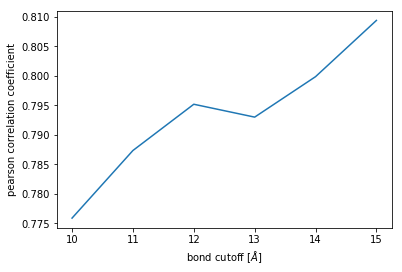

In [19]:
l_cutoff_Bcorrs = np.array(l_cutoff_Bcorrs)
plt.figure()
plt.plot(l_cutoff_Bcorrs[:,0], l_cutoff_Bcorrs[:,1])
plt.xlabel(r"bond cutoff [$\AA$]")
plt.ylabel(r"pearson correlation coefficient")
print "cutoff with highest corrcoef([B_exp, B_nma])=", np.max(l_cutoff_Bcorrs[:,1]), ": ", l_cutoff_Bcorrs[np.argmax(l_cutoff_Bcorrs[:,1]), 0]

d_cutoff = l_cutoff_Bcorrs[np.argmax(l_cutoff_Bcorrs[:,1]), 0]

optimal gamma:  0.243951303462


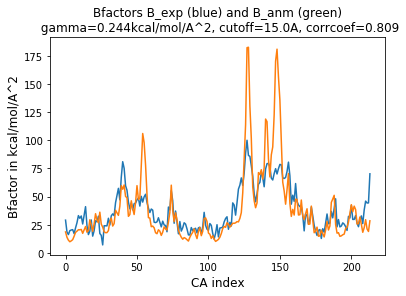

In [20]:
#
# determine optimal value for gamma
#
gamma = 8 * PI**2 * R * TEMP / 3 * xcov[d_cutoff].sum() / B_exp.sum()
print "optimal gamma: ", gamma

#
B_enm = 8 * PI**2 * R * TEMP / 3 / gamma * xcov[d_cutoff]

#
# plot B_exp and B_enm
#
plt.figure()
plt.title("Bfactors B_exp (blue) and B_anm (green)\n gamma=%.3fkcal/mol/A^2, cutoff=%.1fA, corrcoef=%.3f" % (gamma, mycutoff, corrcoef([B_exp,B_nma])[0,1]) )
plt.xlabel("CA index",fontsize=12)
plt.ylabel("Bfactor in kcal/mol/A^2",fontsize=12)
plt.plot(B_exp)
plt.plot(B_enm)
#plt.savefig("./output/"+inputfolder+"/B_nma.vs.B_exp."+inputfolder+".png")

In [21]:
# Now generate a pdb animation of the ENM ...

# covering "movie_length" periods of the first non-trivial eigen mode
movie_length = 50
# considering eigen modes startmode to endmode 
# - the first six eigen modes (modes "0" to "5") are trivial and thus not interesting, and result from
# overall translations and rotations (these have zero eigenvalues are not even considered in the ANM server above)
startmode               = 6
endmode                 = 7
# number of animation frames
numframes               = 500 

# compute ENM
ca_list, eval, evec_trans = compute_ENM(inpdb, d_cutoff, gamma, indir = "input", verbose = True)

# compute ENM animation
compute_ENM_movie(inpdb, ca_list, eval, evec_trans, startmode, endmode, movie_length, numframes)

# you can visualize this pdb animation, e.g., with the program "VMD":
# http://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD
#
# e.g. in VMD: "Extensions"->"Tk Console", and type in:
# mol load pdb 4AKEA_CA_nms_s6_e7_50T.pdb
# mol representation Tube 0.300000 12.000000
# mol selection {all}
# mol addrep top

214 carbon alpha atoms extracted
now diagonalizing Hessian


/home/lukas/mypackages/miniconda2/envs/ase/lib/python2.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in sqrt


In [12]:
#
# 2a) What do you observe? Which region is the most flexible? How is this reflected in the B_factor plots above?
#     ANSWER: The region around CA 150 is the most flexible. This is reflected by the peaks in the B_factor plots
#     in this region. Less flexible is the region around CA 55.
#

In [13]:
# 2b)
# Consider an ENM as a model full of "Hookean springs" that connect pairs of CA-atoms.
# As a whole, the "springs" make the CA atoms more or less flexible.
# How could you "rigidify" the very flexible region from above?
# Hint: You will need to hack yourself into the "compute_ENM" function by modifying the Hessian matrix, which is
# a 3N*3N matrix, where N is the number of CA atoms. 
# So entries in the first 3 rows/columns relate to first CA atom etc.
#
#Idea: increase gamma for the flexible regions

In [14]:
#
# Bonus question 2c):
# ENM scanner to identify residue positions that are 
# most disruptive to the overall dynamics upon alanine mutation
# (Upon request)
#